# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.

# Laboratory 5 - Classification, Classification Networks, Transfer Learning 

The goal of Laboratory 5 is to:
<ol>
  <li> Implement a dataloader for XRay images with a division into: (i) Normal, (ii) COVID19, (iii) Pneumonia cases, including a preprocessing pipeline.
  <li> Introduce the augmentation into the dataloader, including basic intensity and geometrical transformations.
  <li> Familarize yourself with the Tensorboard for logging and visualizing the training process.
  <li> Apply the transfer learning to the ResNet18 architecture (pretrained using ImageNet) and compare different fine-tuning strategies.
  <li> Analyze the classification results using ROC/AUC and confusion matrices.
</ol>

The dataset comes from: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia

You should start by downloading the dataset and uploading it to your Google Drive.

### Introduction

You are already familiar with implementing the basic CNNs, training them using various optimizers, and creating dedicated dataloaders.

During this laboratory, you are going to extend the previous knowledge by:
<ol>
  <li> Basic image augmentation - you are going to implement additional processing step during the loading pipeline.
  <li> Using TensorBoard to visualize the training process.
  <li> Using predefined and pretrained classification architectures (e.g. ResNet18) and fine-tune them to a given problem.
  <li> Using ROC/AUC and confusion matrices to analyze the performance of classification algorithms.
</ol>

### Part I - Mounting the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's start from mounting your Google Drive and unzip the .zip file containing the dataset.

On the left, under the **Files** bar, find a button called **Mount Drive** and choose your Google Drive.
It should appear in the **/content** folder as a **drive** or with different name if using non-default settings.

Then, unzip the file:


In [3]:
input_file = "/content/drive/MyDrive/LAB5_DATASET/archive.zip" # Path to the "archive.zip"
output_folder = "/content/output" # Path to the folder where you would like to unzip the "archive.zip"
# Note - it will require about 5GB of free Google Drive memory.

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

!unzip {input_file} -d {output_folder} # Do this only once, them comment out this command

Streaming output truncated to the last 5000 lines.
  inflating: /content/output/Data/train/COVID19/COVID19(228).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(229).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(23).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(230).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(231).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(232).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(233).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(234).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(235).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(236).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(237).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(238).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(239).jpg  
  inflating: /content/output/Data/train/COVID19/COVID19(24).jpg  
  inflating: 

After the unzipping, go to the directory using your **Google Drive** interface and analyze the dataset structure. You should observe that it is already divided into **training** and **test** folders. Inside the folders you can find three additional subfolders separating the images into: **PNEUMONIA**, **NORMAL**, **COVID19**.

### Part II - XRay Dataloader.

During the laboratory we assume a multiclass clasification scenario. Of course, it is possible that a particular person could suffer both from pneumonia and COVID19 at once, however, this case is extremerly rare and we will ignore it during this laboratory.

Therefore, the problem can be formulated as a multiclass classification problem with three clases: Normal, Pneumonia, COVID19 where each case belongs only to a single of these classes.

Now, you are going to implement a dedicated dataloader.
Since we want to divide the dataset not only into the training and test sets, but also a separate validation set - let's start with creating a **pandas** dataframes containing all the pathes linked with the given class.

In [20]:
### First import the external libraries
import os
import random
import numpy as np
import torch as tc
import torchvision as tv
import pandas as pd
import matplotlib.pyplot as plt
#!pip install SimpleITK
import SimpleITK as sitk
from torch.utils.tensorboard import SummaryWriter


### Create the paths
data_path = os.path.join(output_folder, "Data")
path_to_training_set = os.path.join(data_path, "train")
path_to_testing_set = os.path.join(data_path, "test")
print(f"Folders within training folder: {os.listdir(path_to_training_set)}")
print(f"Folders within testing folder: {os.listdir(path_to_testing_set)}")

### Create the lists containing tuples: (relative_path_to_given_case, class_name)

# Training set
training_set = []
for folder_name in os.listdir(path_to_training_set):
  for case_name in os.listdir(os.path.join(path_to_training_set, folder_name)):
    current_case = (os.path.join(path_to_training_set,folder_name,case_name)) # TODO - build a relative path to the current case
    training_set.append((current_case,folder_name))
# Test set
testing_set = []
for folder_name in os.listdir(path_to_testing_set):
  for case_name in os.listdir(os.path.join(path_to_testing_set, folder_name)):
    current_case = (os.path.join(path_to_testing_set,folder_name,case_name)) # TODO - build a relative path to the current case
    testing_set.append((current_case,folder_name))

# Shuffle the lists and print first 15 cases from each of them
random.seed(666)
random.shuffle(training_set)
random.shuffle(testing_set)

print("Training cases: ")
print(training_set[:15]) # TODO - print first 15 training cases

print("Testing cases: ")
print(testing_set[:15]) # TODO - print first 15 testing cases

Folders within training folder: ['NORMAL', 'PNEUMONIA', 'COVID19']
Folders within testing folder: ['NORMAL', 'PNEUMONIA', 'COVID19']
Training cases: 
[('/content/output/Data/train/NORMAL/NORMAL(1091).jpg', 'NORMAL'), ('/content/output/Data/train/PNEUMONIA/PNEUMONIA(599).jpg', 'PNEUMONIA'), ('/content/output/Data/train/PNEUMONIA/PNEUMONIA(853).jpg', 'PNEUMONIA'), ('/content/output/Data/train/COVID19/COVID19(33).jpg', 'COVID19'), ('/content/output/Data/train/PNEUMONIA/PNEUMONIA(267).jpg', 'PNEUMONIA'), ('/content/output/Data/train/PNEUMONIA/PNEUMONIA(3346).jpg', 'PNEUMONIA'), ('/content/output/Data/train/PNEUMONIA/PNEUMONIA(2338).jpg', 'PNEUMONIA'), ('/content/output/Data/train/PNEUMONIA/PNEUMONIA(1024).jpg', 'PNEUMONIA'), ('/content/output/Data/train/PNEUMONIA/PNEUMONIA(961).jpg', 'PNEUMONIA'), ('/content/output/Data/train/PNEUMONIA/PNEUMONIA(2425).jpg', 'PNEUMONIA'), ('/content/output/Data/train/NORMAL/NORMAL(360).jpg', 'NORMAL'), ('/content/output/Data/train/NORMAL/NORMAL(359).jpg', '

Next, let's create the **.csv** files for the training, validation and test set respectively. The **test.csv** file can be created directly, the **training.csv** and **validation.csv** file should be created by splitting the training dataframe.

In [21]:
training_validation_df = pd.DataFrame(training_set, columns=["Image Path", "Class"])
testing_df = pd.DataFrame(testing_set, columns=["Image Path", "Class"])

print(f"Training/Validation DataFrame size: {len(training_validation_df)}")
print(f"Testing DataFrame size: {len(testing_df)}")

split_ratio = 0.9

training_df = training_validation_df.sample(frac=0.9,random_state=200) # TODO - split the training dataframe (0.9 to training set, 0.1 to validation set)
validation_df = training_validation_df.sample(frac=0.1,random_state=200)  # TODO - split the training dataframe (0.9 to training set, 0.1 to validation set)

print(f"Training DataFrame size: {len(training_df)}")
print(f"Validation DataFrame size: {len(validation_df)}")

### Save the .csv files
training_csv_path = os.path.join(data_path, "training.csv")
validation_csv_path = os.path.join(data_path, "validation.csv")
testing_csv_path = os.path.join(data_path, "testing.csv")

training_df.to_csv(training_csv_path)
validation_df.to_csv(validation_csv_path)
testing_df.to_csv(testing_csv_path)

### Verify the correctness by loading the .csv file and printing basic statistics about the class balance

training_df = pd.read_csv(training_csv_path)
print(f"Training class distribution: ")
# TO DO - print the distribution of training cases

validation_df = pd.read_csv(validation_csv_path)
print(f"Validation class distribution: ")
# TO DO - print the distribution of validation cases

testing_df = pd.read_csv(testing_csv_path)
print(f"Testing class distribution: ")
# TO DO - print the distribution of testing cases


Training/Validation DataFrame size: 5144
Testing DataFrame size: 1288
Training DataFrame size: 4630
Validation DataFrame size: 514
Training class distribution: 
Validation class distribution: 
Testing class distribution: 


You now have three **.csv** files representing the three datasets. Now let's implement a PyTorch dataset/dataloader to load, preprocess and aggregate the images into tensors.

In [35]:
from PIL import Image

class XRayDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, class_mapper):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataset_path = dataset_path
        self.dataframe = pd.read_csv(self.csv_path)
        self.class_mapper = class_mapper # Map class string to integer value

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        current_case = self.dataframe.iloc[idx]
        current_path = os.path.join(self.dataset_path, current_case['Image Path'])
        current_class = current_case['Class']
        
        """
        TODO - implement image loading and preprocessing pipeline
        The output image should be (3x224x224) where each channel contains the same values
        (because ResNet18 is pretrained using RGB data)
        Perform [0-1] normalization
        Return (3x224x224) image and class number (using self.class_mapper)
        """
        class_number = self.class_mapper[current_class] # TODO
        img = Image.open(current_path)
        print(img.size)
        img = img.resize((3,224,224))
        print(img.size)
        img = np.asarray(img)
        return img, class_number


Finally, let's visualize several training cases using **matplotlib**.

In [36]:
batch_size = 16
shuffle = True
class_mapper = {'NORMAL': 0, "COVID19": 1, "PNEUMONIA": 2}
training_dataset = XRayDataset(data_path, training_csv_path, class_mapper)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

print(f"Training dataset size: {len(training_dataset)}")

for images, classes in training_dataloader:
  columns = 4
  rows = 4
  fig = plt.figure(figsize=(4,4))
  for i in range(0, columns*rows):
    img = images[i].squeeze()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,cmap="gray")
    plt.axis(False)
    plt.title(classes[i].item())
 
  break
plt.show()

Training dataset size: 4630
(1168, 784)


TypeError: ignored

### Part III - Dataloader Extension - Basic Augmentation

You can observe that the **training_dataset** contains 4629 training cases. This number is relatively large for 3 classes, however, the heterogeneity of medical data is so huge that deep models require significantly larger amount of data to saturate the performance.

In theory, the best approach is to collect and annotate more data. However, this process is costly and time consuming. Another, simpler and cheaper option, is to perform data augmentation.

Data augmentation is the process of generating synthetic training cases from the already available ones. There are several augmentation possibilities: random geometrical/intensity transformations, generative networks, image registration and various others.

During this laboratory we would like to explore the simplest augmentation possibility: the random gemoetrical/intensity transformations applied during dataloading.

Our next step will to extend the just implemented dataloader by data augmentation. 

Explore the augmentation possibilites withing torchvision: https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor
and introduce them to the dataloader (your choice which augmentation strategies you would like to use).

There are also other augmentation libraries like Albumentations or TorchIO. In practice it is useful to use all of them, depending on the problem being solved.

Additionally, since we are going to use the ResNet18 network - introduce additional transformation to perform the Z-normalization of the data with the following parameters **mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]** <- this transformation should be applied independently of whether the input case is training/validation/test sample.

In [38]:
class XRayDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, class_mapper, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataset_path = dataset_path
        self.dataframe = pd.read_csv(self.csv_path)
        self.class_mapper = class_mapper # Map class string to integer value
        self.transforms = transforms
        self.z_norm = z_norm

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        current_case = self.dataframe.iloc[idx]
        current_path = os.path.join(self.dataset_path, current_case['Image Path'])
        current_class = current_case['Class']

        """
        TODO - extend the previous code by applying transforms in self.transforms
        and optional z_norm with the parameters described above
        """
        class_number = self.class_mapper[current_class]
        img = Image.open(current_path)
        print(img.size)
        img = img.resize((3,224,224))
        print(img.size)
        img = np.asarray(img)
        img = self.transforms(img)
        return img, class_number


And now verify the dataloader again (for the purpose of visualization - turn off the **z_norm**):

In [39]:
from torchvision import transforms

batch_size = 16
shuffle = True
class_mapper = {'NORMAL': 0, "COVID19": 1, "PNEUMONIA": 2}

transforms1 = tc.nn.Sequential(
    transforms.CenterCrop(10),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)# TODO - define transforms here

training_dataset = XRayDataset(data_path, training_csv_path, class_mapper, transforms=transforms1, z_norm=False) # Z norm set to alse for visualization purposes
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

print(f"Training dataset size: {len(training_dataset)}")

for images, classes in training_dataloader:
  columns = 4
  rows = 4
  fig = plt.figure(figsize=(4,4))
  for i in range(0, columns*rows):
    img = images[i].squeeze()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,cmap="gray")
    plt.axis(False)
    plt.title(classes[i].item())
 
  break
plt.show()

Training dataset size: 4630
(1592, 1384)


TypeError: ignored

You should observe that both the orientation and the intensity distribution of the images randomly change after each load. Do all these transformations make sense? Think about that.

The augmentation should help during training to avoid overfitting, however, if applied incorrectly - it may also decrease the model performance.

### Part IV - ResNet18 - Fine-Tuning

During the previous laboratories you implemented your own classification networks. This time, you are going to use a predefined ResNet18 architecture.

There are several reasons why you should consider using already pretrained networks:
<ul>
  <li> The training process is usually time-consuming (especially for large networks).
  <li> The training process is costly. It consumes significant amount of energy and introduced significant carbon footprint.
  <li> Usually the annotated datasets (especially in medicine) are not large enough to make the "training from scratch" successful. Therefore, the transfer learning, either from different domain or from self-supervised training, improves the results.
</ul>

You are going to compare the approaches:
<ol>
  <li> Training the ResNet18 from scratch.
  <li> Training the ResNet18 (pretrained on ImageNet) with all layers unfrozen.
  <li> Training the ResNet18 (pretrained on ImageNet) with only the last classification layer unfrozen.
</ol>

Start by visiting: https://pytorch.org/hub/pytorch_vision_resnet/

Create three ResNet models - two pretrained on ImageNet, and second randomly initialized. You should freeze all the layers expect the last one for the third model.

In [43]:
device = "cuda:0"

### Create and load the model that is going to be trained from scratch
model_from_scratch =tc.hub.load('pytorch/vision:v0.10.0', 'resnet18') # TODO

### Create and load the model that is going to be fine-tuned (all layers)
model_pretrained_all = tc.hub.load('pytorch/vision:v0.10.0', 'resnet18') # TODO

### Create and load the model that is going to be fine-tuned (last layer) and freeze all layers expect the last one
model_pretrained_final = tc.hub.load('pytorch/vision:v0.10.0', 'resnet18') # TODO

### Check the initial results from model randomly initialized
for images, classes in training_dataloader:
    images = images.to(device)
    output = model_from_scratch(images)
    print(f"Output: {tc.nn.Sigmoid()(output)}")
    print(f"Classes: {classes}")
    break

### Check the initial results from one of the pretrained models
for images, classes in training_dataloader:
    images = images.to(device)
    output = model_pretrained_final(images)
    print(f"Output: {tc.nn.Sigmoid()(output)}")
    print(f"Classes: {classes}")
    break

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


(1315, 824)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


TypeError: ignored

The three models should be already defined and initialized.

The next task is to implement a training function. Follow the steps from Laboratory 3, however, this time use TensorBoard to interactively visualize the training process.

Please read: https://medium.com/looka-engineering/how-to-use-tensorboard-with-pytorch-in-google-colab-1f76a938bc34
to understand the process.

In [44]:
### This cell should contain the training function.
from tqdm import tqdm
def training(model, learning_rate, num_epochs):
    model.train()
    optimizer = tc.optim.SGD(model.parameters(), lr=learning_rate)

    criterion = tc.nn.CrossEntropyLoss()
    print('Training')

    train_running_loss = 0.0

    train_running_correct = 0

    counter = 0
    for i, data in tqdm(enumerate(training_dataloader), total=len(training_dataloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
      
        outputs = model(image)
      
        loss = criterion(outputs, labels)
       
        loss.backward()

        optimizer.step()
        print("Epoch:"+counter)
    
    return model
  

In [45]:
### This cell should initialize the training parameters and training/validation/testing dataloaders.
# Training, TensorBoard logger and Dataloader params
learning_rate = 0.002
batch_size = 16
num_epochs = 25 # You should choose the desired number of epochs - 25 may be not enough
shuffle = True
transform = tc.nn.Sequential(
    transforms.CenterCrop(10),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
) # TODO

# Training dataset/dataloader
training_dataset = XRayDataset(data_path, training_csv_path, class_mapper, transforms=transform, z_norm=True)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
# Validation dataset/dataloader
validation_dataset = XRayDataset(data_path, validation_csv_path, class_mapper, transforms=None, z_norm=True)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# Testing dataset/dataloader
testing_dataset = XRayDataset(data_path, testing_csv_path, class_mapper, transforms=None, z_norm=True)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In this cell initialize the TensorBoard.

In [46]:
# TODO - load TensorBoard to interactively visualize the training process
%reload_ext tensorboard

Train the model from scratch:

In [ ]:
### This cell should contain the training from scratch.
# TODO
model_from_scratch = training(model=model_from_scratch, learning_rate=learning_rate,num_epochs=num_epochs)

NameError: name 'model_from_scratch' is not defined

Fine-tune the model by training all layers:

In [47]:
### This cell should contain finetuning all the layers.
# TODO
model_pretrained_all = training(model=model_pretrained_all, learning_rate=learning_rate,num_epochs=num_epochs)

Training


  0%|          | 0/290 [00:00<?, ?it/s]

(1538, 1164)


TypeError: ignored

Fine-tune the model by training the last layer:

In [48]:
### This cell should contain finetuning just the last classification layer.
# TODO
model_pretrained_final = training(model=model_pretrained_final, learning_rate=learning_rate,num_epochs=num_epochs=

SyntaxError: ignored

You have successfully trained the three models. The next task is to analyze the results.

### Part V - Results Analysis

The next part is to analyze the results on the test set for all the models.

Start with accumulating the predicitions and scores for all the models. Scores will be required to draw the ROCs and calculate AUCs.

In [49]:
def accumulate_predictions_and_scores(model, dataloader):
  predictions = []
  targets = []
  scores = []
  """
  The function should perform a full run through the given dataloader and accumulate:
  predictions = the predicted class for a given case (Nx1 or N)
  target = the real class for a given case (Nx1 or N)
  scores = the calculated probability that a given case belongs to the given class (Nx3)
  """
  return predictions, targets, scores

scratch_predictions, scratch_targets, scratch_scores = accumulate_predictions_and_scores(model_from_scratch, testing_dataloader)
finetuned_all_predictions, finetuned_all_targets, finetuned_all_scores = accumulate_predictions_and_scores(model_pretrained_all, testing_dataloader)
finetuned_last_predictions, finetuned_last_targets, finetuned_last_scores = accumulate_predictions_and_scores(model_pretrained_final, testing_dataloader)

Now calculate and visualize the confusion matrices:

Confusion matrix: From Scratch: [[ 97   0  15]
 [ 23   0  22]
 [ 93   0 265]]
              precision    recall  f1-score   support

      Normal       0.46      0.87      0.60       112
     COVID19       0.00      0.00      0.00        45
   Pneumonia       0.88      0.74      0.80       358

    accuracy                           0.70       515
   macro avg       0.44      0.54      0.47       515
weighted avg       0.71      0.70      0.69       515

Confusion matrix: All Layers: [[ 29   0  83]
 [  0  30  15]
 [  0   2 356]]
              precision    recall  f1-score   support

      Normal       1.00      0.26      0.41       112
     COVID19       0.94      0.67      0.78        45
   Pneumonia       0.78      0.99      0.88       358

    accuracy                           0.81       515
   macro avg       0.91      0.64      0.69       515
weighted avg       0.84      0.81      0.77       515

Confusion matrix: Last Layer: [[  0   0 112]
 [  0   0  45]
 [  0   0 358]]
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

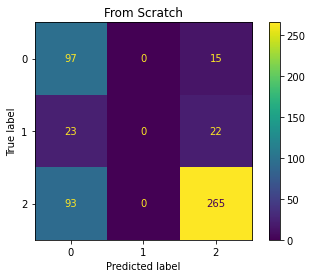

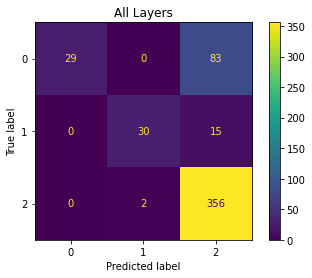

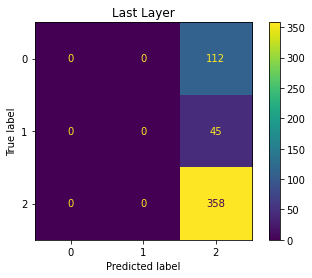

In [ ]:
import sklearn.metrics as metrics
target_names = ["Normal", "COVID19", "Pneumonia"]

# TODO - using sklearn.metrics - print and show confusion matrices as be

Finaly plot the ROC curves and calculate the AUC for each model and dataset:

Normal from scratch AUC: 0.8551599610067352
COVID19 from scratch AUC: 0.4592434988179669
Pneumonia from scratch AUC: 0.8336832366651248


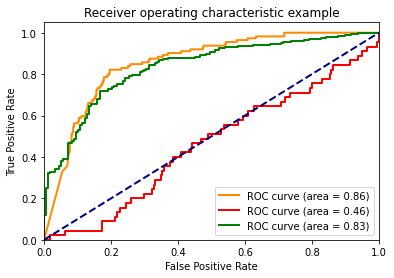

In [ ]:
### This cell should contain the ROC/AUC for the model trained from scratch.

targets = np.array(scratch_targets)
scores = np.array(scratch_scores)

# TODO - using sklearn.metrics - show ROCs and calculate AUCs
roc_score = metrics.roc_auc_score(scores,targets)
auc_score = metrics.accuracy_score(scores,targets)
plt.plot(roc_score , auc_score)

Normal (fined-tuned all) AUC: 0.9357275788727402
COVID19 (fined-tuned all) AUC: 0.9590070921985816
Pneumonia (fined-tuned all) AUC: 0.9138970928370637


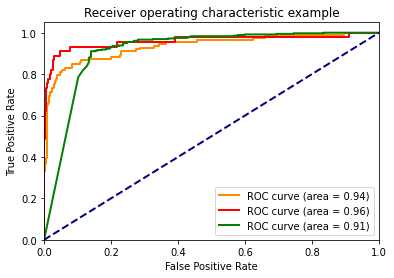

In [ ]:
### This cell should contain the ROC/AUC for the model fine-tuned (all layers)

targets = np.array(finetuned_all_targets)
scores = np.array(finetuned_all_scores)

# TODO - using sklearn.metrics - show ROCs and calculate AUCs

# TODO - using sklearn.metrics - show ROCs and calculate AUCs
roc_score = metrics.roc_auc_score(scores,targets)
auc_score = metrics.accuracy_score(scores,targets)
plt.plot(roc_score , auc_score)

Normal (fined-tuned last layer only) AUC: 0.9593450903934776
COVID19 (fined-tuned last layer only) AUC: 0.7118203309692671
Pneumonia (fined-tuned last layer only) AUC: 0.6579101875244635


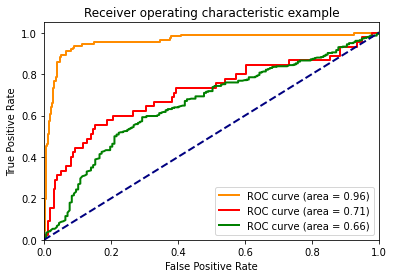

In [ ]:
### This cell should contain the ROC/AUC for the model fine-tuned (just last layer)

targets = np.array(finetuned_last_targets)
scores = np.array(finetuned_last_scores)

# TODO - using sklearn.metrics - show ROCs and calculate AUCs

roc_score = metrics.roc_auc_score(scores,targets)
auc_score = metrics.accuracy_score(scores,targets)
plt.plot(roc_score , auc_score)

You should observe that the results are strongly biased towards the most represented class (Pneumonia).

The issue is called class imbalance. There are several possible solutions. The most frequent are:
<ul>
  <li> Creating dedicated sampling strategy that balances batches during training.
  <li> Introducing weighting during objective function calculation and increasing the weight for the classes with smaller representation.
</ul>

In practice, the class imbalance is not straightfoward, especially for multilabel classification when it is not obvious how to find the balance between sampling and objective function weighting.

Another thing you can inspect are the results on the training/validation sets for each training strategy and with/without augmentation. It is useful to observe the influence of the fine-tuning strategy or augmentation on the final outcome. Moreover, you should increase the number of epochs to observe the results after saturation.

### Conclusion

This is the end of Laboratory 5. You should be now familiar with:
<ol>
  <li> Basic geometrical and intensity augmentation strategies.
  <li> Using TensorBoard to visualize the training process.
  <li> Fine-tuning pre-trained networks.
  <li> Calculating confusion matrix and ROC/AUC to analyze the classification results.
</ol>

The next lecture / laboratory will discuss the segmentation architectures. You are going to implement the U-Net architecture by yourself for the automatic analysis of endoscopy images and perform quantitative analysis of the obtained results.